In [1]:
import torch
import numpy as np
# import time
# import math
import matplotlib.pyplot as plt
import torch.nn as nn
# import torch.nn.functional as F
import pandas as pd
import torch.utils.data as data
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve


In [2]:
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [3]:
def prepare_data(df, std=None, mean=None):
  numerical_data = df[["YearBuilt","Size(sqf)","Floor","N_Parkinglot(Ground)","N_Parkinglot(Basement)","N_manager","N_elevators","N_FacilitiesInApt","N_FacilitiesNearBy(Total)","N_SchoolNearBy(Total)"]]
  #numerical_data = df[[YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)]]

  time_to_bus_stop = pd.Series.to_frame(df["TimeToBusStop"].str.replace('-','~').str.split('~',1,expand=True)[1].str.slice(stop=-3)).rename(columns={1: 'TimeToBusStop'})
  time_to_subway = pd.Series.to_frame(df["TimeToSubway"].str.replace('-','~').str.split('~',1,expand=True)[1].str.slice(stop=-3)).rename(columns={1: 'TimeToSubway'})
  time_to_subway.fillna(2*np.nanmax(time_to_subway.astype("float").values),inplace=True)
  subway = pd.Series.to_frame(df.TimeToSubway != "no_bus_stop_nearby").rename({"TimeToSubway":"Subway"})
  numerical_data =  pd.concat([numerical_data,time_to_bus_stop], axis=1).astype(float)
  if std is None or mean is None:
    std=np.std(numerical_data)
    mean=np.mean(numerical_data)
  numerical_data -= mean
  numerical_data /= std
  boolean_data = pd.concat([df["HeatingType"] == "central_heating",df["AptManageType"] == "self_management"], axis=1)
  categorical_data = pd.get_dummies(df[["SubwayStation","TimeToSubway"]])
  df_data =  pd.concat([numerical_data,boolean_data,categorical_data], axis=1)
  df_data = torch.from_numpy(df_data.astype(float).values)
  if "SalePrice" in df:
    temp = df["SalePrice"]
    q = []
    for a in temp:
        q.append(a)
    for i in range(len(q)):
        if q[i] <= 100000:
            q[i] = 0
        elif q[i] <= 350000:
            q[i] = 1
        else:
            q[i] = 2
    df["SalePrice"] = q
    print(df["SalePrice"])
    targets = torch.from_numpy(df["SalePrice"].astype(int).to_numpy())
    return data.TensorDataset(df_data,targets), std, mean
  else:
    return data.TensorDataset(df_data), std, mean

In [4]:
df = pd.read_csv('train_data.csv')
df_train=df.sample(frac=0.8,random_state=200) #random state is a seed value
df_test=df.drop(df_train.index)
df_eval = pd.read_csv('test_data.csv')
train_dataset, std, mean = prepare_data(df_train)
test_dataset = prepare_data(df_test, std, mean)[0]
eval_dataset = prepare_data(df_eval, std, mean)[0]
train_data_loader = data.DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True)
test_data_loader = data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True, drop_last=False)
eval_data_loader = data.DataLoader(eval_dataset, batch_size=len(eval_dataset), shuffle=False, drop_last=False)

4084    2
1202    1
1406    0
2078    1
2051    1
       ..
3286    1
1320    1
1832    1
708     1
3575    1
Name: SalePrice, Length: 3299, dtype: int64
17      1
18      2
48      2
67      1
73      1
       ..
4100    1
4103    1
4107    0
4110    1
4115    1
Name: SalePrice, Length: 825, dtype: int64


Przygotowanie sieci

In [5]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_hidden2, num_outputs):
        # Initialize the modules we need to build the network
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear3 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        x = self.act_fn(x)
        x = self.linear3(x)
        return x

Utworzenie sieci i przygotowanie do jej nauki

In [8]:
model = SimpleClassifier(num_inputs=len(train_dataset[0][0]), num_hidden=50, num_hidden2=26, num_outputs=1)

#optimizer = torch.optim.SGD(model.parameters(), lr = 0.00001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.00001)
targets = torch.from_numpy((df_train.SalePrice).astype(int).values)
loss_module = nn.L1Loss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
model.train() 
loss_progress = []

Epoch: 0, loss: 0.435
Epoch: 1, loss: 0.345
Epoch: 2, loss: 0.304
Epoch: 3, loss: 0.288
Epoch: 4, loss: 0.258
Epoch: 5, loss: 0.255
Epoch: 6, loss: 0.212
Epoch: 7, loss: 0.196
Epoch: 8, loss: 0.202
Epoch: 9, loss: 0.202
Epoch: 10, loss: 0.217
Epoch: 11, loss: 0.198
Epoch: 12, loss: 0.192
Epoch: 13, loss: 0.212
Epoch: 14, loss: 0.197
Epoch: 15, loss: 0.164
Epoch: 16, loss: 0.189
Epoch: 17, loss: 0.199
Epoch: 18, loss: 0.193
Epoch: 19, loss: 0.168
Epoch: 20, loss: 0.172
Epoch: 21, loss: 0.174
Epoch: 22, loss: 0.18
Epoch: 23, loss: 0.2
Epoch: 24, loss: 0.179
Epoch: 25, loss: 0.176
Epoch: 26, loss: 0.19
Epoch: 27, loss: 0.221
Epoch: 28, loss: 0.175
Epoch: 29, loss: 0.191
Epoch: 30, loss: 0.171
Epoch: 31, loss: 0.191
Epoch: 32, loss: 0.201
Epoch: 33, loss: 0.175
Epoch: 34, loss: 0.165
Epoch: 35, loss: 0.173
Epoch: 36, loss: 0.179
Epoch: 37, loss: 0.158
Epoch: 38, loss: 0.171
Epoch: 39, loss: 0.194
Epoch: 40, loss: 0.178
Epoch: 41, loss: 0.176
Epoch: 42, loss: 0.184
Epoch: 43, loss: 0.145
Ep

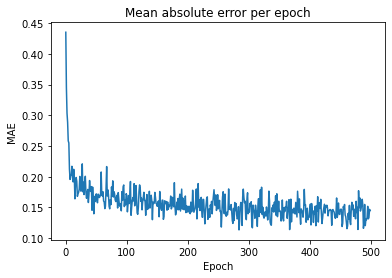

In [9]:
for epoch in range(500):
    for data_inputs, data_labels in train_data_loader:

        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        preds = model(data_inputs.float())
        preds = preds.squeeze(dim=1) 
        
        loss = loss_module(preds, data_labels.float())
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, loss: {loss.item():.3}")
    loss_progress.append(loss.item())
plt.plot(loss_progress)
plt.title('Mean absolute error per epoch')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.show()

Przygotowanie do ewaluacji

In [11]:
model.eval()

SimpleClassifier(
  (linear1): Linear(in_features=26, out_features=50, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=50, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=1, bias=True)
)

Ewaluacja

In [12]:
with torch.no_grad(): 
  data_inputs, data_labels = next(iter(test_data_loader))
  data_inputs = data_inputs.to('cpu')
  data_labels = data_labels.to('cpu')
  model.to('cpu')
  preds = model(data_inputs.float())
  preds = preds.squeeze(dim=1)
  loss = loss_module(preds, data_labels.float())
  preds_p = preds > 0.2
  correct = preds_p == data_labels
  tp = sum(preds_p * correct)
  tn = sum(~preds_p * correct)
  fp = sum(preds_p) - tp
  fn = sum(~preds_p) - tn
  total = len(preds_p)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
 
  # evaluation_data.csv
  data_inputs = next(iter(eval_data_loader))[0]
  preds_eval = model(data_inputs.float())
  preds_eval = preds_eval.squeeze(dim=1)

print(f"BCE: {loss:1.3f}")
print(f"True positives: {100*tp/total:1.3f}%")
print(f"True negatives: {100*tn/total:1.3f}%")
print(f"False positives: {100*fp/total:1.3f}%")
print(f"False negatives: {100*fn/total:1.3f}%")
print(f"Accuracy: {100*(tp+tn)/total:1.3f}%")
print(f"Precision: {100*precision:1.3f}%")
print(f"Recall: {100*recall:1.3f}%")
print(f"F1: {200*precision*recall/(precision+recall):1.3f}%")
"""
roc_auc = roc_auc_score(data_labels, preds)
fpr, tpr, thresholds = roc_curve(data_labels, preds)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="test")
display.plot()
roc_auc
"""

BCE: 0.127
True positives: 66.545%
True negatives: 10.667%
False positives: 19.636%
False negatives: 3.152%
Accuracy: 77.212%
Precision: 77.215%
Recall: 95.478%
F1: 85.381%


'\nroc_auc = roc_auc_score(data_labels, preds)\nfpr, tpr, thresholds = roc_curve(data_labels, preds)\ndisplay = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="test")\ndisplay.plot()\nroc_auc\n'

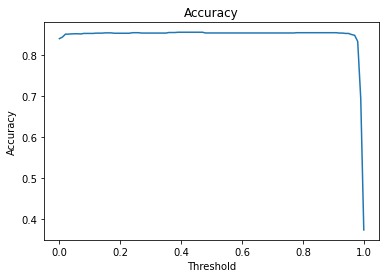

In [13]:
with torch.no_grad(): 
  data_inputs, data_labels = next(iter(test_data_loader))
  data_inputs = data_inputs.to('cpu')
  data_labels = data_labels.to('cpu')
  model.to('cpu')
  preds = model(data_inputs.float())
  preds = preds.squeeze(dim=1)
  loss = loss_module(preds, data_labels.float())
  F1 = np.zeros((101,1))
  for k in range(101):
    threshold = k/100
    preds_p = preds > threshold
    correct = preds_p == data_labels
    tp = sum(preds_p * correct)
    tn = sum(~preds_p * correct)
    fp = sum(preds_p) - tp
    fn = sum(~preds_p) - tn
    total = len(preds_p)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    F1[k] = 2*precision*recall/(precision+recall)
  plt.plot(np.linspace(0,100,101)/100,F1)
  plt.title('Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Threshold')
  plt.show()

Zapisanie modelu

In [14]:
pd.DataFrame(preds_eval).to_csv("maj_brus.csv", index=False, header=None)